# Lista 4

## Uczenie maszynowe i sztuczna inteligencja

## Wstęp
Na tych zajęciach przejdziemy już do wykorzystywania bardziej zaawansowanych funkcji *PyTorcha*,
które przydają się na co dzień do konstruowania sieci neuronowych.

# Zadanie 1 (10pt)

W celu zaliczenia zadania należy uzupełnić wszystkie brakujące elementu kodu, wykonać wszystkie polecenia i wyuczyć model.



## Cel zadania
Celem zadania jest zapoznanie z podstawowymi funkcjami biblioteki *PyTorch* do tworzenia i uczenia sieci neuronowych a w szczególności z:
*   Automatycznym liczeniem gradientów grafem obliczeniowym (autograd)
*   Algorytmami off-line, on-line a także pojęciem mini-batch
*   Algorytmami optymalizacji sieci neuronowych
*   Liczeniem wartości funkcji straty
*   Przekształceniami nieliniowymi
*   Modułem `torch.nn`

In [1]:
import math
import warnings
from typing import Tuple

import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

## Autograd - automatyczne liczenie gradientów

Na poprzednich liście zaimplementowaliśmy funkcję wstecznej propagacji. W tym celu liczyliśmy pochodne (gradienty). Przyjrzyjmy się najpierw funkcji
$$f(x, y) = 3x^2 + y^3$$
Możemy tę funkcję różniczkować po dwóch zmiennych: $x$ i $y$:
$$\frac{\partial f}{\partial x} = 6x$$

$$\frac{\partial f}{\partial y} = 3y^2$$

Jeżeli funkcję $f(x,y)$ złożymy z funkcją $g(x) = x^2$ tworząc funkcję $h(x, y) = f(g(x), y)$ to z **reguły łańcuchowej** pochodna takiej funkcji wyniesie:

$$\frac{\partial h}{\partial x} = \frac{\partial f}{\partial g} \frac{\partial g}{\partial x} = (6 (x^2)) (2 x) = 12 x^3$$

Tego typu obliczenia przy wielu warstwach sieci (a więc przy wielu złożeniach funkcji liniowych i nieliniowych) stają się mocno skomplikowane. Na szczęście *PyTorch* dostarcza `torch.autograd` - silnik do automatycznego liczenia gradientów. Jak on działa? Najpierw zdefiniujmy wektory $\mathbf x$ i $\mathbf y$.

In [2]:
x = torch.tensor([0., 1., 5.], requires_grad=True)
y = torch.tensor([8., 2., 4.], requires_grad=True)

Zauważ, że tworząc tensor przekazaliśmy parametr `requires_grad=True`.
 Sprawia on, że wszystkie operacje dokonane na tym tensorze są śledzone i
 tensor wynikowy będzie "pamiętał" przy użyciu jakiej operacji powstał. 
Policzmy naszą funkcję $f( \mathbf x, \mathbf y)$ dla tych tensorów.

In [3]:
z = 3*x**2 + y**3
z

tensor([512.,  11., 139.], grad_fn=<AddBackward0>)

Jak widać uzyskany tensor ma także zapisany parametr `grad_fn=<AddBackward0>`, czyli że powstał z dodania dwóch tensorów - dodawanie jest ostatnią operacją, która została wykonana, żeby otrzymać ten tensor. Dokonajmy propagacji wstecznej w celu policzenia gradientów.

In [4]:
grad_tensors = torch.tensor([1., 1., 1.])
z.backward(grad_tensors)
print(x.grad == 6*x)
print(y.grad == 3*y**2)
print(x.grad)

tensor([True, True, True])
tensor([True, True, True])
tensor([ 0.,  6., 30.])


Nie zgadzają nam się wartości. - **u mnie się zgadzają - aby przestały trzeba wykonać pownie komórke z z oraz ta** - Wynika to z kolejnej własności pytorchowego autograda - gradienty w tensorach są **akumulowane**. Jak wykonasz powyższą komórkę wielokrotnie to zobaczysz że wartości `x.grad` rosną dokładnie o $12x_i^3$ po każdym wykonaniu -**aby to zaobserwować trzbea wykonać komórkę poniżej gdzie liczymy h(x,y) potem komórkę gdzie liczymy z a dopiero potem powyższą**-. Akumulacja gradientów jest przydatna w niektórych architekturach sieci neuronowych. Dlatego też trzeba *explicite* wyzerować gradienty.

In [5]:
x.grad.data.zero_()
a = 3*(x**2)**2 + y**3
a.backward(grad_tensors)
print(x.grad)
print(12*(x**3))
assert (x.grad == 12*(x**3)).all()

tensor([   0.,   12., 1500.])
tensor([   0.,   12., 1500.], grad_fn=<MulBackward0>)


Najpierw zacznijmy od załadowania zbioru danych i podzielenia go na zbiór uczący i testowy.

In [6]:
X, y = load_iris(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

y_test

tensor([0, 2, 0, 1, 2, 1, 1, 2, 2, 0, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 0, 0, 2, 0,
        1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 0, 2, 2, 1, 0,
        0, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1], dtype=torch.int32)

## `nn.Module` oraz `CrossEntropyLoss`

Na wykładzie implementowaliśmy funkcję sigmoid, inicjalizację parametrów oraz propagację w przód i wsteczną. Tym razem nie będzie trzeba tego robić, jednakże zdefiniujemy architekturę sieci przy użyciu modułu `torch.nn`.

***Zaimplementuj*** klasę Perceptron - klasę dziedziczącą po `nn.Module` z jedną warstwą transformacji liniowej (Perceptrona, [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)). Na razie ***pomiń*** transformację nieliniową (np. sigmoid). 

In [7]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Linear(input_dim, output_dim)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


*Uwaga*: Można także nadal używać `torch.nn` i nie wykorzystywać gotowych warstw sieci tylko samemu implementować operacje na tensorach:

```
class Perceptron(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.weights = nn.Parameter(
          torch.randn(in_dim, out_dim) / math.sqrt(in_dim)
        )
        self.bias = nn.Parameter(torch.zeros(out_dim))

    def forward(self, xb: torch.Tensor):
        return xb @ self.weights + self.bias
```

***Przetestuj*** poprawność swojej implementacji.

In [8]:
model = Perceptron(4, 3) 
y_pred_0 = model(X_train[0])
print(y_pred_0)

assert isinstance(y_pred_0, torch.FloatTensor)
assert len(y_pred_0) == 3

tensor([2.6850, 4.1196, 4.6170], grad_fn=<ViewBackward0>)


Wykorzystanie `nn.Linear` nie tylko odciążyło nas z implementacji operacji na tensorach, ale także z inicjalizacji parametrów modelu - inicjalizacja parametrów jest domyślnie implementowana przez daną warstwę. Jeżeli uruchomisz powyższy kod wielokrotnie to zauważysz, że za każdym razem otrzymujesz inny tensor wyjściowy. Wynika to z tego, że początkowe parametry modelu są domyślnie **losowane**. Oznacza to, że proces uczenia będzie **niedeterministyczny** - każde uruchomienie da inny wynik parametrów, które model się nauczy.

Pozostało jeszcze dodanie nieliniowej transformacji do sieci, ale nie będziemy tego robić. Dodatkowo zamiast tworzyć osobny klasyfikator na klasę, zastosujemy jeden klasyfikator. W tym celu zmieniamy funkcję kosztu. Do klasyfikacji wieloklasowej wykorzystamy funkcję **straty krzyżowej entropii** (Cross Entropy Loss).

$$\text{loss} = -\frac{1}{N}\sum_{i}^{N}\log(\text{softmax}(x_{i}){y_{i}}), $$ gdzie $N$ oznacza liczbę przypadków, $x_{i}$ wyjście z ostatniej warstwy $i$-tej instancji, $y_{i}$ klasę $i$-tej instancji.

**Softmax** jest przekształceniem nielinowym powszechnie używanym jako ostatnia warstwa sieci neuronowej służącej do klasyfikacji. Jej mocną stroną jest to, że suma wszystkich elementów tensora będących na jej wyjściu wynosi $1$. Dzięki temu możemy wyjście sieci interpretować jako przypisanie prawdopodbieństwa dla klasyfikacji dla danej próbki.

Dla danego wektora $\mathbf x = (x_1, x_2, \ldots, x_i, \ldots, x_C)$ funkcja Softmax jest zdefiniowana jako:
$$\text{softmax}(x_{i}) = \frac{\exp(x_{i})}{\sum_{j}^{C} \exp(x_{j})},$$
gdzie $C$ oznacza liczbę klas.

W tym zadaniu nie będziemy implementować tych funkcji samemu tylko wykorzystamy gotową implementację w bibliotece torch. Implementację znajdziemy w [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Przyjmuje ona "surowe" wartości, dlatego że oblicza również funkcję **LogSoftmax**. Alternatywnie możemy nałożyć funkcję aktywacji LogSoftmax z modułu [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) i obliczyć negatywny logarytm funkcji wiarygodności (ang. *negative log likelihood*) [`torch.nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss). `torch.nn.NLLLoss` nie wykonuje operacji logarytmowania tylko oczekuje zlogarytmowanego wejścia.

**LogSoftmax** wykorzystany jest tutaj nieprzypadkowo. Funkcja softmax w oryginalnej postaci nie jest odporna na wystąpienie niestabilności numerycznych. W przypadku liczenia entropii krzyżowej możemy wykorzystać skalę logarytmiczną do przeprowadzenia operacji. Dzięki przeniesieniu obliczania logarytmu do funkcji Softmax możemy zastąpić dzielenie na różnicę logarytmów, czyli zamiast powyższej definicji funkcja LogSoftmax przyjmuję następującą postać:

$$\text{logsoftmax}(x_{i}) = x_{i} - \log \bigg({\sum_{j}^{C} \exp(x_{j})}\bigg)$$

Dodatkowo stosowany jest także trik polegający na zastąpieniu operacji $\log \bigg({\sum_{j}^{C} \exp(x_{j})}\bigg)$ operacją **LogSumExp**, zdefiniowaną jako

$$\text{logsumexp}(\mathbf x) = \max(\mathbf x) + \log \bigg({\sum_{j}^{C} \exp(x_{j} - \max(\mathbf x))}\bigg).$$

Pozwala to pozbyć się dużych wartości $x_{j}$ podczas obliczania $\exp$.




## Algorytmy online i offline (`DataLoader`)

Na poprzednich listach implementowaliśmy **algorytm offline** (alternatywnie batchowy lub deterministyczny, ang. *offline*, *batch*, *deterministic*) tzn. taki, który przetwarza od razu wszystkie dane. Jednakże implementując sieci neuronowe tworzymy często algorytmy **online** (alternatywnie stochastyczne, ang. *online*, *stochastic*), które przetwarzają dane w "kawałkach" lub wręcz mogą dostawać je "na bieżąco" bez konieczności posiadania wszystkich danych przed uruchomieniem algorytmu. Są różne powody, dla których tak się robi, ale najczęściej jest tak, że przy głębszych architekturach i bardziej złożonych obiektach (np. obrazach) byłoby fizycznie niemożliwe pomieścić te wszystkie dane w pamięci RAM lub VRAM (RAM na GPU) wraz z parametrami modelu.

Liczbę próbek w algorytmach stochastycznych w sieciach neuronowych określa się jako **minibatch size** lub po prostu **batch size**. Przy czym określenie *batch size* nie odnosi się tutaj do algorytmów batchowych (operujących na całym zbiorze danych), tylko do algorytmów online/minibatch. Po prostu *batch size* jest określeniem krótszym (ale mniej poprawnym) niż *minibatch size*, stąd też powszechnie używa się tego pierwszego. Z tego też powodu czasami niektórzy używają określenia *batch* na *minibatch* - warto mieć to na uwadze przy komunikowaniu się z innymi osobami.

Do zaimplementowania minibatchy wykorzystamy [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

***Zaimplementuj*** funkcję `to_dataloader`, która `X_train` i `y_train` oraz `X_test` i `y_test` umieści w dwóch osobnych instancjach klasy `DataLoader` z wielkością minibatacha równą `batch_size`

In [9]:
def to_dataloader(
    X_train: torch.Tensor, 
    y_train: torch.Tensor, 
    X_test: torch.Tensor, 
    y_test: torch.Tensor, 
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader]:
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_ds = TensorDataset(X_test, y_test)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, test_dl

***Przetestuj*** implementację

In [10]:
train_loader, test_loader = to_dataloader(
    X_train=X_train,  y_train=y_train, 
    X_test=X_test, y_test=y_test, 
    batch_size=32
)

for sample in test_loader:
    print(sample)

[tensor([[5.1000, 3.8000, 1.9000, 0.4000],
        [7.4000, 2.8000, 6.1000, 1.9000],
        [4.6000, 3.2000, 1.4000, 0.2000],
        [6.4000, 2.9000, 4.3000, 1.3000],
        [7.3000, 2.9000, 6.3000, 1.8000],
        [7.0000, 3.2000, 4.7000, 1.4000],
        [5.1000, 2.5000, 3.0000, 1.1000],
        [7.2000, 3.2000, 6.0000, 1.8000],
        [6.7000, 2.5000, 5.8000, 1.8000],
        [5.0000, 3.4000, 1.5000, 0.2000],
        [6.1000, 3.0000, 4.9000, 1.8000],
        [5.1000, 3.5000, 1.4000, 0.2000],
        [6.9000, 3.2000, 5.7000, 2.3000],
        [6.2000, 3.4000, 5.4000, 2.3000],
        [6.0000, 3.4000, 4.5000, 1.6000],
        [6.1000, 3.0000, 4.6000, 1.4000],
        [6.8000, 3.0000, 5.5000, 2.1000],
        [6.8000, 2.8000, 4.8000, 1.4000],
        [5.7000, 2.5000, 5.0000, 2.0000],
        [6.2000, 2.2000, 4.5000, 1.5000],
        [5.7000, 4.4000, 1.5000, 0.4000],
        [5.0000, 3.5000, 1.6000, 0.6000],
        [6.7000, 3.3000, 5.7000, 2.5000],
        [4.4000, 2.9000, 1.4000, 

## Ewaluacja modelu - metryki

_**Zaimplementuj**_ funkcję `validate`, które dla danego modelu, funkcji straty i loadera zwróci średnią wartość funkcji straty oraz dokładność (ang. _accuracy_) dla danych z `dataloader`.

In [11]:
def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch)
        all += len(y_pred)
        loss += len(y_pred) * loss_fn(y_pred, y_batch.long()) 
        correct += count_correct(y_pred, y_batch)
    return loss / all, correct / all


***Przetestuj*** swoją implementację

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
val_train, acc_train = validate(model, loss_fn, test_loader)
print(val_train)
print(acc_train)

tensor(0.9413, grad_fn=<DivBackward0>)
tensor(0.5333)


## Uczenie

Przed uzupełnieniem poniżej implementacji została nam jeszcze jedna istotna kwestia do poruszenia. Otóż do tej pory aktualizację parametrów dokonywaliśmy wg prostej formuły - mnożyliśmy gradienty przez współczynnik uczenia (ang. *learning rate*) i odejmowaliśmy od parametrów. Jednakże do uczenia sieci neuronowych stosujemy często optymalizatory (ang. *optimiser*), które mogą implementować różne podejścia do uaktualniania parametrów modelu. Wykorzystamy tutaj algorytm **Adam** (ang. *adaptive moment estimation*), który dostosowuje współczynnik uczenia do poszczególnych parametrów i jest często optymizatorem pierwszego wyboru.

***Uzupełnij i przetestuj*** poniższą implementację uczenia modelu.

Epoch 0: train loss = 2.930 (acc: 0.333), test loss = 2.901 (acc: 0.333)
Epoch 1: train loss = 2.877 (acc: 0.333), test loss = 2.849 (acc: 0.333)
Epoch 2: train loss = 2.825 (acc: 0.333), test loss = 2.797 (acc: 0.333)
Epoch 3: train loss = 2.775 (acc: 0.333), test loss = 2.747 (acc: 0.333)
Epoch 4: train loss = 2.725 (acc: 0.333), test loss = 2.697 (acc: 0.333)
Epoch 5: train loss = 2.675 (acc: 0.333), test loss = 2.647 (acc: 0.333)
Epoch 6: train loss = 2.626 (acc: 0.333), test loss = 2.598 (acc: 0.333)
Epoch 7: train loss = 2.577 (acc: 0.333), test loss = 2.550 (acc: 0.333)
Epoch 8: train loss = 2.529 (acc: 0.333), test loss = 2.502 (acc: 0.333)
Epoch 9: train loss = 2.481 (acc: 0.333), test loss = 2.455 (acc: 0.333)
Epoch 10: train loss = 2.435 (acc: 0.333), test loss = 2.409 (acc: 0.333)
Epoch 11: train loss = 2.390 (acc: 0.333), test loss = 2.363 (acc: 0.333)
Epoch 12: train loss = 2.345 (acc: 0.333), test loss = 2.319 (acc: 0.333)
Epoch 13: train loss = 2.302 (acc: 0.333), test 

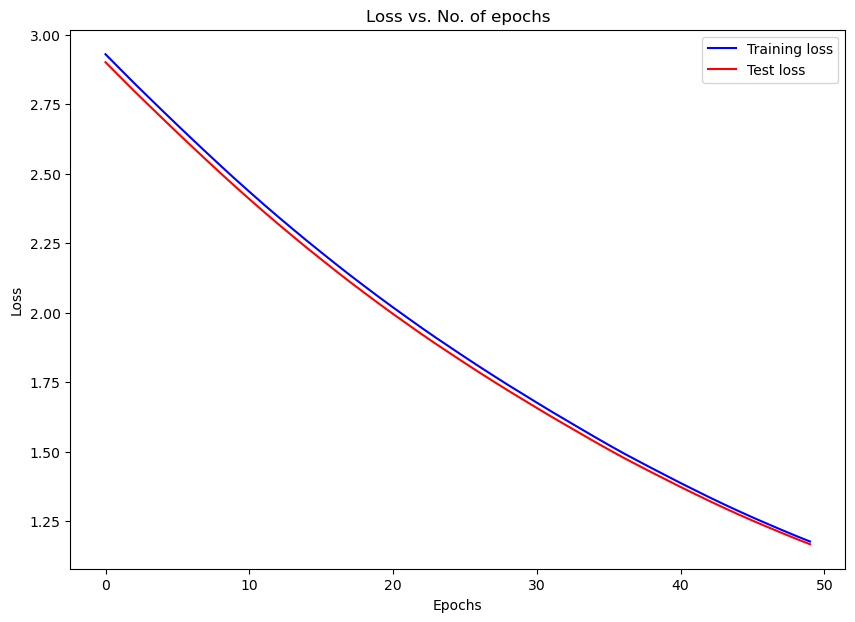

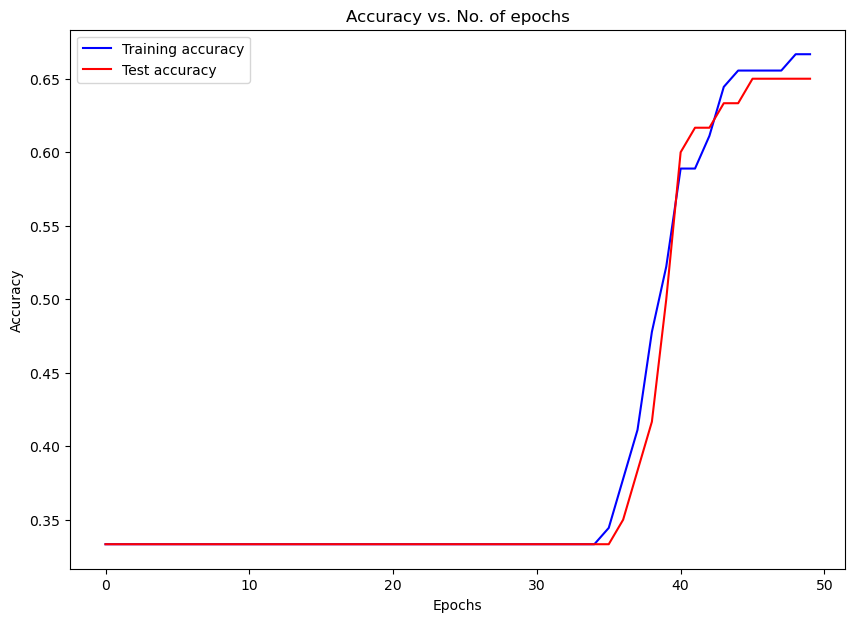

In [13]:
import matplotlib.pyplot as plt

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    test_dl: DataLoader, epochs: int, 
    print_metrics: str = True, 
    print_plots: str = True
):
    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch.long()) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()
        
        if print_metrics: 
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropout czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_dl)
                test_loss, test_acc = validate(model, loss_fn, test_dl)

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)

                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"test loss = {test_loss:.3f} (acc: {test_acc:.3f})"
                )       
    if print_plots:
        # Wartości funkcji straty dla kolejnych epok
        plt.figure(figsize=(10, 7))
        plt.plot(train_losses, color='blue', label='Training loss')
        plt.plot(test_losses, color='red', label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. No. of epochs')
        plt.legend()
        plt.show()

        # Wartości accuracy dla kolejnych epok
        plt.figure(figsize=(10, 7))
        plt.plot(train_accs, color='blue', label='Training accuracy')
        plt.plot(test_accs, color='red', label='Test accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. No. of epochs')
        plt.legend()
        plt.show()

    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm

train_dl, test_dl = to_dataloader(
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    batch_size=32
)
perceptron = Perceptron(4, 3)
optimiser = optim.Adam(perceptron.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
fit(
    model=perceptron, optimiser=optimiser, loss_fn=loss_fn, 
    train_dl=train_dl, test_dl=test_dl, epochs=50
)

***Uzupełnij*** funkcję `fit`, aby ta mogła logować metryki (*loss*, *accuracy*) per epokę. Po zebraniu historii uczenia ***przedstaw*** następujące wykresy:
- Wykres wartości funkcji kosztu w zależności od epoki uczenia dla zbioru uczącego i testowego
- Wykres wartości metryki *accuracy* w zależności od epoki uczenia dla zbioru uczącego i testowego 

Metryki dla obu zbiorów przedstaw na jednym wykresie jako serie. ***Uzupełnij*** etykiety osi i tytuły wykresów.

***Popraw*** model, tak aby otrzymać dokładność na zbiorze testowym wynoszącą co najmniej 90%. W tym celu dobierz odpowiedni współczynnik uczenia i liczbę epok. 
Do porównania badanych hiperparametrów użyj zbioru walidacyjnego. Podziel zbiór testowy na dwie równe części, jeden który będzie służyć do walidacji hiperparametrów, a drugi, który będzie służył do ewaluacji znalezionej najlepszej pary hiperparametrów. W tym celu możesz wykorzystać funkcję [`torch.utils.data.random_split`](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split) z ustawionym parametrem `generator=torch.Generator().manual_seed(1)`. Przedstaw również wykresy o których mowa w punkcie powyżej tym razem z uwzględniam trzech zbiorów [(uczącego, walidacyjnego i testowego)](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets).

In [14]:
from torch.utils.data import TensorDataset, DataLoader, random_split

def to_dataloader_with_val(
    X_train: torch.Tensor, 
    y_train: torch.Tensor, 
    X_test: torch.Tensor, 
    y_test: torch.Tensor, 
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_ds = TensorDataset(X_train, y_train)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # Convert the test data to a TensorDataset
    test_ds = TensorDataset(X_test, y_test)

    # Split the test set into a validation set and a new test set
    val_size = len(test_ds) // 2
    test_size = len(test_ds) - val_size
    val_ds, test_ds = random_split(test_ds, [val_size, test_size], generator=torch.Generator().manual_seed(1))

    # Create data loaders for the validation and test data
    val_dl = DataLoader(val_ds, batch_size=batch_size)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    return train_dl, val_dl, test_dl


def fit_with_val(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, test_dl: DataLoader, epochs: int, 
    print_metrics: str = True, 
    print_plots: str = True
):
    train_losses = []
    val_losses = []
    test_losses = []
    train_accs = []
    val_accs = []
    test_accs = []
    val_acc = -1.0

    for epoch in range(epochs):
        for X_batch, y_batch in train_dl:
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch.long()) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()
        
        model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropout czy BatchNorm
        with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
            train_loss, train_acc = validate(model, loss_fn, train_dl)
            val_loss, val_acc = validate(model, loss_fn, val_dl)
            test_loss, test_acc = validate(model, loss_fn, test_dl)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            test_accs.append(test_acc)

        if print_metrics: 
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"val loss = {val_loss:.3f} (acc: {val_acc:.3f}), "
                    f"test loss = {test_loss:.3f} (acc: {test_acc:.3f})"
                )       
    if print_plots:
        # Wartości funkcji straty dla kolejnych epok
        plt.figure(figsize=(10, 7))
        plt.plot(train_losses, color='blue', label='Training loss')
        plt.plot(val_losses, color='green', label='Validation loss')
        plt.plot(test_losses, color='red', label='Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. No. of epochs')
        plt.legend()
        plt.show()

        # Wartości accuracy dla kolejnych epok
        plt.figure(figsize=(10, 7))
        plt.plot(train_accs, color='blue', label='Training accuracy')
        plt.plot(val_accs, color='green', label='Validation accuracy')
        plt.plot(test_accs, color='red', label='Test accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. No. of epochs')
        plt.legend()
        plt.show()

    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropout czy BatchNorm

    return val_acc



Best model: lr = 0.01, epochs = 150, validation accuracy = 1.0
Epoch 0: train loss = 1.062 (acc: 0.389), val loss = 1.192 (acc: 0.267), test loss = 0.936 (acc: 0.467)
Epoch 1: train loss = 0.889 (acc: 0.656), val loss = 0.974 (acc: 0.600), test loss = 0.810 (acc: 0.700)
Epoch 2: train loss = 0.787 (acc: 0.667), val loss = 0.831 (acc: 0.600), test loss = 0.757 (acc: 0.733)
Epoch 3: train loss = 0.772 (acc: 0.667), val loss = 0.789 (acc: 0.667), test loss = 0.777 (acc: 0.667)
Epoch 4: train loss = 0.792 (acc: 0.667), val loss = 0.796 (acc: 0.667), test loss = 0.815 (acc: 0.667)
Epoch 5: train loss = 0.791 (acc: 0.667), val loss = 0.792 (acc: 0.667), test loss = 0.819 (acc: 0.667)
Epoch 6: train loss = 0.762 (acc: 0.667), val loss = 0.767 (acc: 0.667), test loss = 0.784 (acc: 0.667)
Epoch 7: train loss = 0.736 (acc: 0.667), val loss = 0.748 (acc: 0.667), test loss = 0.746 (acc: 0.667)
Epoch 8: train loss = 0.717 (acc: 0.656), val loss = 0.738 (acc: 0.667), test loss = 0.716 (acc: 0.700)
E

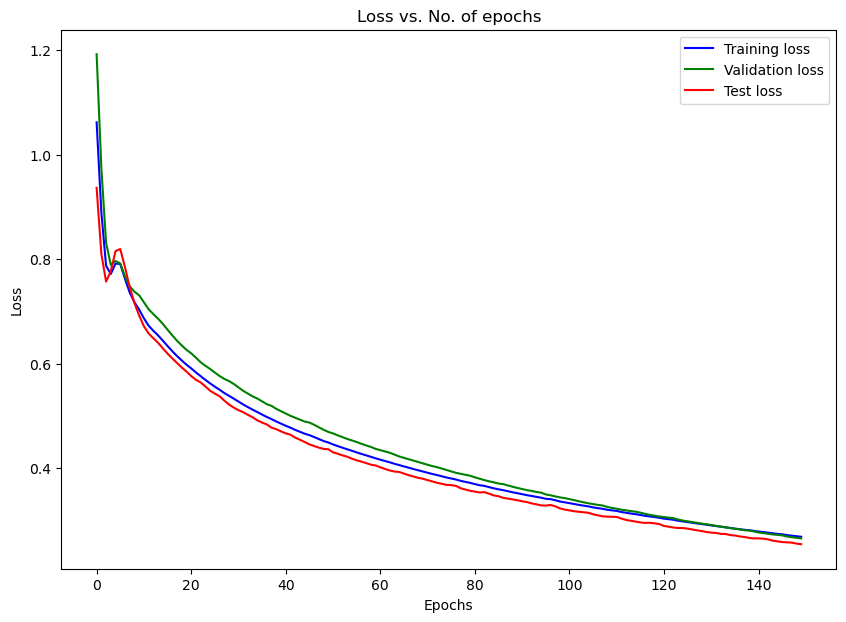

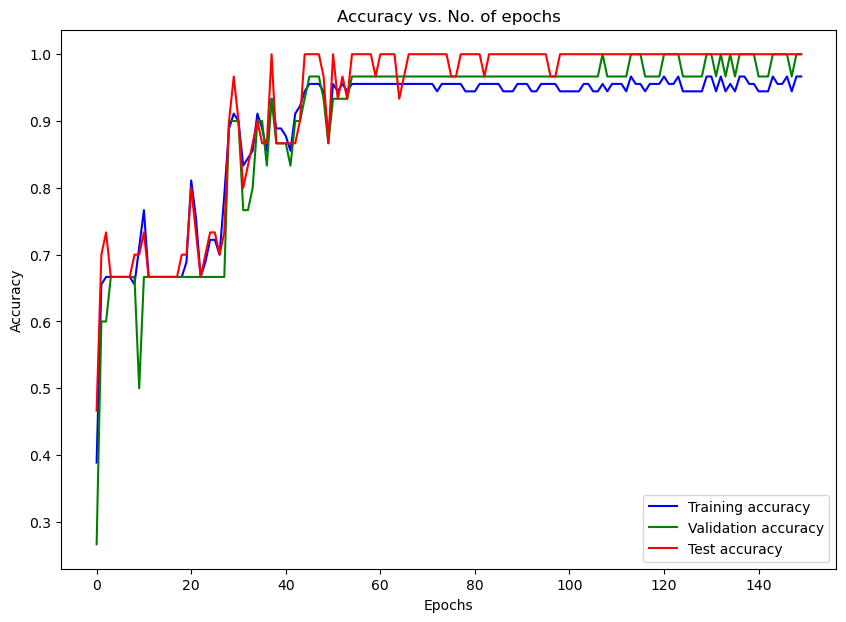

tensor(1.)

In [15]:
# Hiperparametry po których sprawdzamy
learning_rates = [0.001, 0.01, 0.1]
num_epochs = [50, 100, 150, 200]

best_val_acc = 0
best_lr = 0
best_epochs = 0

train_dl, val_dl, test_dl = to_dataloader_with_val(
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test, 
    batch_size=32
)

# Iterujemy po wszystkich kombinacjach
for lr in learning_rates:
    for epochs in num_epochs:
        model = Perceptron(4, 3)
        optimiser = torch.optim.Adam(model.parameters(), lr=lr)
        # Sprawdzamy val_acc dla tego modelu
        val_acc = fit_with_val(model, optimiser, loss_fn, train_dl, val_dl, test_dl, epochs, print_metrics=False, print_plots=False)
        # Jesli jest lepsza zapisujemy hiperparametry
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_lr = lr
            best_epochs = epochs

print(f"Best model: lr = {best_lr}, epochs = {best_epochs}, validation accuracy = {best_val_acc}")

# Odpalamy nowy model z hiperparametrami ktore dawaly najlepsze wyniki
best_model = Perceptron(4, 3)
optimiser = torch.optim.Adam(best_model.parameters(), lr=best_lr)
fit_with_val(best_model, optimiser, loss_fn, train_dl, val_dl, test_dl, best_epochs, print_metrics=True, print_plots=True)

# Zadanie 2 (15pt)

W celu zaliczenia zadania należy uzupełnić wszystkie brakujące elementu kodu, wykonać wszystkie polecenia i wyuczyć model.

## Cel zadania

Celem zadania jest zapoznanie z:
*   Wielowarstwowymi sieciami neuronowymi (MLP)
*   Podstawami przetwarzania obrazów (ang. Computer Vision)
*   Metodami regularyzacji sieci neuronowych
*   Techniką wczesnego zatrzymania uczenia
*   Tensorboardem

# Zbiór danych do klasyfikacji obrazów

W ramach zadania klasyfikacji obrazów wykorzystamy zbiór [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Zbiór danych składa się z 70.000 obrazów o wymiarach 28x28 pikseli przedstawiających różne typy odzieży w skali szarości. Podobnie jak [MNIST](https://en.wikipedia.org/wiki/MNIST_database), w zbiorze występuje 10 klas.  

### Wczytanie danych
Do wczytania zbioru danych możemy wykorzystać [`torchvision`](https://pytorch.org/vision/stable/index.html), który zawiera popularne zbiory danych, modele i transformacje danych z dziedziny przetwarzania obrazów (ang. *computer vision*). 

Oryginalne dane są zapisane w postaci liczb całkowitych z zakresu 0-255 w postaci [obrazu PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html). Do przeskalowania danych wykorzystamy transformację [`torchvision.transforms.ToTensor`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor). Transformacje danych możemy przekazywać do loadera zbioru danych z `torchvision`. Można przekazać zarówno pojedynczą operację transformacji lub złożyć kilka operacji za pomocą [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose)

**Uwaga** 
Operacje transform są realizowane w "locie" w momencie wywołania `__getitem__`.

In [1]:
import os

from torchvision.datasets import FashionMNIST 
from torchvision import transforms

path = './data'
os.makedirs(path, exist_ok=True)

train_data = FashionMNIST(
    root=path, 
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = FashionMNIST(
    root=path, 
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



# Wizualizacja danych

W odróżnieniu od poprzednich zadań, gdzie ręcznie rysowaliśmy krzywe uczenia i metryki, tym razem wykorzystamy narzędzie do wizualizacji [`tensorboard`](https://www.tensorflow.org/tensorboard). O ile oryginalnie Tensorboard był rozwijany dla Tensorflowa, to i tak możemy wykorzystać w PyTorchu. Funkcje pomocnicze znajdują się w module [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html). 

Tensorboard bazuje na logach, które umieszczamy w odpowiednim folderze. Dlatego najpierw zaczniemy od stworzenia takich logów, a dopiero w późniejszym etapie uruchomimy tensorboarda. Zapisywanie logów odbywa się za pomocą klasy [`SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter#torch.utils.tensorboard.writer.SummaryWriter).

In [ ]:
from torch.utils.tensorboard import SummaryWriter

log_dir = './logs/'
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir)

Wyświetlmy teraz kilka obrazów ze zbioru uczącego. Do wyświetlenia siatki zdjęć wykorzystamy funkcję pomocniczą [`torchvision.utils.make_grid`](https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid). Do elementów zbioru uczącego, bez nałożonej transformacji, możemy się odwołać za pomocą obiektu `data`. Metoda `make_grid` oczekuje danych w formacie `Batch x Liczba Kanałów x Wysokość x Szerokość`, dlatego musimy dostosować
 odpowiednio wejście. Pełny kod zdefiniowano poniżej. Następnie 
przekazujemy utworzony w taki sposób grid, do utworzonej wcześniej 
instancji klasy `SummaryWriter` za pomocą metody `add_image`. 

In [ ]:
import torchvision

images_to_plot = 64
img_grid = torchvision.utils.make_grid(
    train_data.data[0:images_to_plot].reshape(images_to_plot, 1, 28, 28)
)

writer.add_image('Train data sample', img_grid)

Logi nie są już w tym momencie puste, a więc możemy uruchomić Tensorboarda. Tensorboard w środowisku Jupytera uruchamiamy za pomocą komend `%load_ext tensorboard` i `% tensorboard --logdir ./logs`. Można też po uruchomieniu zobaczyć tensorboard w osobnej zakładce (zazwyczaj http://localhost:6006 lub dalsze porty 6007, 6008, ...).

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $log_dir

# Implementacja architektury MLP

Teraz przejdziemy do implementacji architektury wielowarstwowego perceptrona (ang. *multilayer perceptron*, *MLP*). 
Do zdefiniowania architektury wykorzystaj moduł `torch.nn.Sequential`, przekazując obiekt `OrderDict` zawierający nazwę i warstwy. 

Przykład

```python
nn.Sequential(OrderedDict([
    ('dense1', nn.Linear(20, 10)),
    ('relu1', nn.ReLU()),
]))
```


***Zaimplementuj*** podaną architekturę sieci neuronowej

| Nazwa warstwy | Opis |
| --- | --- |
| `flatten` | Spłaszczenie obrazu z wymiaru **28x28** na wymiar **784** |
| `dense1` | Warstwa w pełni połączona z **256** neuronami |
| `relu1` | Funkcja aktywacji **ReLU** |
| `dense2` | Warstwa w pełni połączona z **128** neuronami |
| `relu2` | Funkcja aktywacji **ReLU** |
| `dense3` | Warstwa w pełni połączona z **10** neuronami |


*Metoda inicjalizacji wag i biasów*: domyślna dla warstwy `torch.nn.Linear` (Rozkład jednostajny z zakresem wartości $\mathcal{U}(-\sqrt{k}, \sqrt{k})$, gdzie $k = \frac{1}{\text{in\_features}}$)




In [ ]:
from collections import OrderedDict

import torch
from torch import nn

class MLP(nn.Module): 
  def __init__(self):
    super().__init__()

    self.net = nn.Sequential(
        ____
    )
  
  def forward(self, x: torch.Tensor):
      ____

Mając zdefiniowaną architekturę i wczytany zbiór danych możemy teraz 
wyświetlić naszą architekturę w postaci grafu obliczeniowego w 
Tensorboardzie. W tym celu wykorzystamy poniższy kod.

In [ ]:
mlp = MLP()

writer.add_graph(mlp, input_to_model=train_data[0][0])
writer.close()

Tym razem wykorzystany podział zbioru na trzy części: [treningowy, walidacyjny (valid) i testowy](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets). Z tą różnicą, że zbiór testowy pozostawimy bez zmian, aby mieć możliwość porównania się do wyników [innych klasyfikatorow](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/).   

***Zaprogramuj*** nowy podział danych:
-  Zbiór treningowy podziel na dwie części:
   - zbiór treningowy/uczący zawierający 54.000 elementy,
   - zbiór walidacyjny zawierający 6.000 elementów.
- Zbiór testowy ma pozostać w oryginalnej formie.
- Zachowaj oryginalne proporcje klas w nowo utworzonych zbiorach, tj. dokonaj stratyfikacji. Operację wykonaj na indeksach i utwórz podzbiory używając klasy `torch.utils.data.Subset`. Ustaw `random_state` podziału na $1$.
- Utwórz instancje klasy `DataLoader` dla wszystkich części zbiorów. Ustaw wartość parametru `batch_size` na $128$

In [ ]:
from typing import Tuple

import numpy as np
from torch.utils.data import  DataLoader, Subset
from sklearn.model_selection import train_test_split

def split_train_data(
    train_data: torchvision.datasets.FashionMNIST
) -> Tuple[Subset, Subset]:
    train_idx, valid_idx = train_test_split(
        ____,
        test_size=___, stratify=____,
        random_state=____
    )
    train = Subset(____)
    valid = Subset(____)
    return train, valid

train, valid = split_train_data(train_data)

train_loader = DataLoader(____)
valid_loader = DataLoader(____)
test_loader = DataLoader(____)

## Inicjalizacja parametrów sieci
Domyślne parametry (w tym metoda inicjalizacji wag / biasów) w bibliotece `PyTorch` są dobrane tak, aby dla różnych zadań i architektur dawały optymalne wyniki. W niektórych przypadkach dobranie odpowiedniej metody inicjalizacji wag i biasów do zastosowanej architektury, może usprawnić proces uczenia, przez co poprawić osiągi modelu. Poniżej przedstawiono przykład zastąpienia domyślnej metody inicjalizacji na inicjalizację parametrów z rozkładu normalnego dla pojedynczej warstwy.

```python
from torch import nn

layer = nn.Linear(100, 10)
nn.init.normal_(layer.weight, mean=0.0, std=1.0)
```
Alternatywnie, możemy zmienić inicjalizacje dla kilku warstw, wykorzystując metodę `apply`.

```python
net = nn.Sequential(
      nn.Linear(100, 10),
      nn.Linear(10, 1)
)

def init_layer_params(layer: nn.modules.Module):
  if isinstance(layer, nn.Linear):
    nn.init.normal_(layer.weight, mean=0.0, std=1.0)
    nn.init.normal_(layer.bias, mean=0.0, std=1.0)

net.apply(init_layer_params)



## Generowanie wykresów w Tensorboardzie

Logowanie metryk do Tensorboarda odbywa się z wykorzystaniem metody `writer.add_scalar`. Wartości dodajemy pojedynczo. Poniżej przedstawiono przekazanie wartości funkcji straty z kolejnych epok do writera.

```python
train_loss_values = [0.78, 0.65, 0.5]
for epoch_id, train_loss in enumerate(train_loss_values):
  writer.add_scalar(
    tag='training loss', 
    scalar_value=train_loss, 
    global_step=epoch_id+1
  )
```
Nie musimy przekazać wartości osobno dla train i test można umieścić je w jednym obiekcie. Odbywa się to za pomocą metody `writer.add_scalars`. Przykładowe wywołanie dla wartości funkcji straty ze zbioru treningowego i walidacyjnego.

```python
train_loss_values = [0.78, 0.65, 0.5]
valid_loss_values = [0.96, 0.78, 0.79]

for epoch_id, (train_loss, valid_loss) in (
  enumerate(zip(train_loss_values, valid_loss_values))
):
    print(train_loss, valid_loss)
    writer.add_scalars(
      main_tag='loss', 
      tag_scalar_dict={
        'train': train_loss,
        'valid': valid_loss
      }, 
      global_step=epoch_id+1
    )
```

Wykresy do Tensorboard dodawane są za pomocą metody `add_figure`. Poniżej zaprezentowano przykład dodania macierzy pomyłek do Tensorboarda.

```python
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(10, 5))
cm = confusion_matrix(
    y_true=[0, 1, 0, 0], 
    y_pred=[1, 1, 1, 0]
)
sns.heatmap(cm, annot=True, figure=fig)
writer.add_figure(tag='Confusion matrix', figure=fig)
```

Można wykorzystując funkcję `fit` z poprzedniego zadania ***dodaj***:
- Generowanie wykresów krzywej uczenia dla Tensorboarda w zależności od epoki dla zbioru uczącego oraz walidacyjnego
- Generowanie wykresów dokładności (ang. *accuracy*) dla Tensorboarda w zależności od epoki dla zbioru uczącego oraz walidacyjnego
- Macierz pomyłek dla zbioru testowego po zakończeniu uczenia

***Przeprowadź uczenie*** modelu sieci wykorzystując następujące hiperparametry uczenia: 

- Funkcja straty: ***Entropia krzyżowa***
- Wielkość paczki (*min-batch*): ***128***  
- Optymalizator: ***Adam*** 
- Współczynnik uczenia: ***0.01***  
- Liczba epok: ***50*** 

***Dokonaj ewaluacji*** modelu po zakończeniu uczenia na zbiorze testowym.

In [ ]:
# TUTAJ KOD

# [Wczesne zatrzymywanie uczenia (ang. *early stopping*)](https://en.wikipedia.org/wiki/Early_stopping)

Jak można zauważyć jakość klasyfikacji na zbiorze walidacyjnym po kilkunastu epokach zaczyna oscylować w takim samym zakresie wartości. Możemy wykorzystać technikę wczesnego zatrzymania, w momencie kiedy funkcja straty na zbiorze walidacyjnym przestaje maleć, zatrzymywany jest cały proces. Liczba epok po których nie dochodzi do poprawy wartości funkcji kosztu, i zatrzymywany jest proces uczenia, jest kontrolowany hiperparametrem cierpliwości (ang. *patience*).

Do zaimplementowania tej techniki potrzebne nam będzie zapisywanie modelu po każdej epoce w której doszło do poprawy jakości modelu. W tym celu używamy metody `torch.save`, który zapisuje zadany mu obiekt w postaci pythonowego pickla. W bibliotece `PyTorch` dostęp do wyuczalnych parametrów mamy za pomocą `state_dict`. `state_dict` jest to pythonowy słownik, który mapuje każdą warstwę do tensora jej parametrów. Jeżeli chcemy użyć modelu do inferencji wystarczy, że zapiszemy wyłącznie parametry modelu. W przypadku kiedy chcemy mieć możliwość douczenia modelu w późniejszym momencie musimy również zapisać `state_dict` z wykorzystanego optymalizatora. Do nas należy decyzja co chcemy zapisać, więc oprócz samych parametrów warto zapisać numer epoki, wartości funkcji kosztu, hiperparametry modelu czy optymalizatora.

Przykładowy kod do zapisywania modelu
```python
torch.save(
    obj={
      'epoch': epoch,
      'loss': loss,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'model_args': model_args,
      'optim_args': optim_args
    },
    f=output_path
)
```

 Wczytanie modelu składa się z kilku kroków:
 - Wczytujemy zapisany przez nas punkt kontrolny (ang. *checkpoint*)
 - Inicjalizujemy model i optymalizator od nowa.
 - Ładujemy obiekt `state_dict` odpowiednio do modelu i optymalizatora

Przykładowy kod do wczytania modelu.

```python
checkpoint = torch.load(output_path)

model = ModelCls(**checkpoint['model_args'])
optimizer = OptimazerCls(**checkpoint['optim_args'])

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
```

**Zaimplementuj technikę wczesnego zatrzymania** wraz z zapisywaniem punktów kontrolnych modelu

***Zastosuj*** dwie wybrane techniki regularyzacji sieci (L1, L2, Dropout). Sprawdź czy poprawiły one wyniki Twojego modelu na zbiorze testowym. Dodaj wykresy do Tensorboarda, dokonaj porównania i podsumowania wyników

**UWAGA** W przypadku zastosowania metody optymalizacji `Adam` i regularyzacji `L2` należy zastosować optymalizator `AdamW`. Więcej szczegółów można znaleźć w publikacji autorów optymalizatora `AdamW` https://arxiv.org/abs/1711.05101

In [ ]:
# TUTAJ KOD